In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [88]:
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib
from math import pow, sqrt, ceil, cos, sin, pi
from collections import OrderedDict

from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.neighbors import KDTree

In [36]:
from PIL import Image as PILImage
import matplotlib.patches as patches

In [3]:
from Analysis.annotations import Annotation
from Analysis.image import Image
from Analysis.expert import Expert, DatasetType, ProjectType
from Analysis.statistics import Statistics

In [4]:
from utils import *

In [5]:
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25

In [94]:
def point_on_circle(center, radius, angle):
    '''
        Finding the x,y coordinates on circle, based on given angle
    '''
    #center of circle, angle in degree and radius of circle
    x = center[0] + (radius * cos(angle))
    y = center[1] + (radius * sin(angle))

    return x,y

In [125]:
symbols = {}
offset = {}

for id, symbol, angle in zip([3,4,5,6,7,8,9,11,12,13], 
                        ["o", "D", '*', "<", "X", "^", ">","v", "P", "p"], 
                             np.linspace(0, 360, num = 10)):
    symbols["Participant_{}".format(id)] = symbol
    offset["Participant_{}".format(id)] = point_on_circle((0,0), 1, angle)
offset

{'Participant_3': (1.0, 0.0),
 'Participant_4': (-0.6669380616522619, 0.7451131604793488),
 'Participant_5': (-0.11038724383904756, -0.9938886539233752),
 'Participant_6': (0.8141809705265618, 0.5806111842123143),
 'Participant_7': (-0.9756293127952373, 0.21942525837900473),
 'Participant_8': (0.4871876750070059, -0.8732972972139946),
 'Participant_9': (0.32578130553514806, 0.9454451549211168),
 'Participant_11': (-0.9217395798793158, -0.3878094208292295),
 'Participant_12': (0.903705111970614, -0.42815542808445156),
 'Participant_13': (-0.2836910914865273, 0.9589157234143065)}

### LabelBox EIPH Results

#### Annotations:

In [6]:
#Name	Dataset	ProjectType	Nr. Annotations	Seconds

seconds = [139,118,93,103,76,194,79,48,66,120]
num_annotations = [254,232,218,224,219,204,231,175,211,242]
mious = [0.56,0.49,0.59,0.43,0.34,0.49,0.68,0.34,0.49,0.49]

label_box_data = []
for second, num_anno, miou in zip(seconds, num_annotations, mious):
    label_box_data.append(["Participant_0", DatasetType.EIPH_LabelBox, ProjectType.Annotation, num_anno, second, miou])
     
label_box_data.append(["GT", DatasetType.EIPH_LabelBox, ProjectType.GroundTruth, 282, 0, 0])

#### Algorithm

In [7]:
#Name	Dataset	ProjectType	Nr. Annotations	Seconds

seconds = [113,79,24,67,119,11,53,60,138,117]
num_annotations = [238,241,238,236,235,231,229,233,237,232]
mious = [0.58,0.58,0.59,0.5,0.46,0.57,0.54,0.59,0.66,0.57]

for second, num_anno, miou in zip(seconds, num_annotations, mious):
    label_box_data.append(["Participant_0", DatasetType.EIPH_LabelBox, ProjectType.ExpertAlgorithm, num_anno, second, miou])
     
labelbox_results = pd.DataFrame(label_box_data, columns=['Name', 'Dataset', 'ProjectType', 'Nr. Annotations', 'Seconds', 'mIoU'])
labelbox_results.head()

Name        Dataset ProjectType  Nr. Annotations  Seconds  mIoU
0  Participant_0  EIPH_LabelBox  Annotation              254      139  0.56
1  Participant_0  EIPH_LabelBox  Annotation              232      118  0.49
2  Participant_0  EIPH_LabelBox  Annotation              218       93  0.59
3  Participant_0  EIPH_LabelBox  Annotation              224      103  0.43
4  Participant_0  EIPH_LabelBox  Annotation              219       76  0.34

In [8]:
path = Path("Results/*/*")
files = glob(str(path)+"/Participants/*.txt")

users_first_round = []

for file_name in files:
    participant = "Participant_" + Path(file_name).stem.split("_")[-1]
    dataset_type = DatasetType.Asthma
    project_type = ProjectType.Annotation if "FirstRound" in file_name else ProjectType.ExpertAlgorithm
    
    if "EIPH" in file_name:
        dataset_type = DatasetType.EIPH_Exact
    elif "Mitosen" in file_name:
        dataset_type = DatasetType.MitoticFigure
    
    
    expert = Expert(participant, BBType.Detected, dataset_type, project_type)
    expert.add_file(file_name)

    users_first_round.append(expert)

In [9]:
files_gt = glob(str(path)+"/GT/ground truth.txt")

gt_results = []
for file_name in files_gt:
    
    participant = Path(file_name).stem.split("_")[-1]
    dataset_type = DatasetType.Asthma
    project_type = ProjectType.GroundTruth
    
    if "EIPH" in file_name:
        dataset_type = DatasetType.EIPH_Exact
    elif "Mitosen" in file_name:
        dataset_type = DatasetType.MitoticFigure
        
    gt = Expert(participant, BBType.GroundTruth, dataset_type, project_type)
    gt.add_file(file_name)

    gt_results.append(gt)
    
gt_results

[ground truth:  Annos: 458 Seconds: 0.0 Type: Asthma Project: GroundTruth,
 ground truth:  Annos: 237 Seconds: 0.0 Type: EIPH_Exact Project: GroundTruth,
 ground truth:  Annos: 712 Seconds: 0.0 Type: MitoticFigure Project: GroundTruth]

In [10]:
statistics = Statistics(users_first_round + gt_results)

In [11]:
global_statistics = statistics.calc_statistics()
global_statistics = pd.concat([global_statistics, labelbox_results])
global_statistics

Name        Dataset      ProjectType  Nr. Annotations  \
0   Participant_11         Asthma       Annotation              408   
1   Participant_12         Asthma       Annotation              410   
2   Participant_13         Asthma       Annotation              402   
3    Participant_3         Asthma       Annotation              397   
4    Participant_4         Asthma       Annotation              413   
5    Participant_5         Asthma       Annotation              406   
6    Participant_6         Asthma       Annotation              402   
7    Participant_7         Asthma       Annotation              409   
8    Participant_8         Asthma       Annotation              410   
9    Participant_9         Asthma       Annotation              406   
10   Participant_8         Asthma  ExpertAlgorithm              414   
11  Participant_11     EIPH_Exact       Annotation              220   
12  Participant_12     EIPH_Exact       Annotation              232   
13  Participant_13     EIPH_Exact       Annotation              180   
14   Participant_3     EIPH_Exact       Annotation              213   
15   Participant_4     EIPH_Exact       Annotation              236   
16   Participant_5     EIPH_Exact       Annotation              190   
17   Participant_6     EIPH_Exact       Annotation              199   
18   Participant_7     EIPH_Exact       Annotation              212   
19   Participant_8     EIPH_Exact       Annotation              197   
20   Participant_9     EIPH_Exact       Annotation              182   
21   Participant_8     EIPH_Exact  ExpertAlgorithm              231   
22  Participant_11  MitoticFigure       Annotation              637   
23  Participant_12  MitoticFigure       Annotation              334   
24  Participant_13  MitoticFigure       Annotation              351   
25   Participant_3  MitoticFigure       Annotation              654   
26   Participant_4  MitoticFigure       Annotation              694   
27   Participant_5  MitoticFigure       Annotation              884   
28   Participant_6  MitoticFigure       Annotation              673   
29   Participant_7  MitoticFigure       Annotation              482   
30   Participant_8  MitoticFigure       Annotation              725   
31   Participant_9  MitoticFigure       Annotation              628   
32   Participant_8  MitoticFigure  ExpertAlgorithm              760   
33    ground truth         Asthma      GroundTruth              458   
34    ground truth     EIPH_Exact      GroundTruth              237   
35    ground truth  MitoticFigure      GroundTruth              712   
0    Participant_0  EIPH_LabelBox       Annotation              254   
1    Participant_0  EIPH_LabelBox       Annotation              232   
2    Participant_0  EIPH_LabelBox       Annotation              218   
3    Participant_0  EIPH_LabelBox       Annotation              224   
4    Participant_0  EIPH_LabelBox       Annotation              219   
5    Participant_0  EIPH_LabelBox       Annotation              204   
6    Participant_0  EIPH_LabelBox       Annotation              231   
7    Participant_0  EIPH_LabelBox       Annotation              175   
8    Participant_0  EIPH_LabelBox       Annotation              211   
9    Participant_0  EIPH_LabelBox       Annotation              242   
10              GT  EIPH_LabelBox      GroundTruth              282   
11   Participant_0  EIPH_LabelBox  ExpertAlgorithm              238   
12   Participant_0  EIPH_LabelBox  ExpertAlgorithm              241   
13   Participant_0  EIPH_LabelBox  ExpertAlgorithm              238   
14   Participant_0  EIPH_LabelBox  ExpertAlgorithm              236   
15   Participant_0  EIPH_LabelBox  ExpertAlgorithm              235   
16   Participant_0  EIPH_LabelBox  ExpertAlgorithm              231   
17   Participant_0  EIPH_LabelBox  ExpertAlgorithm              229   
18   Participant_0  EIPH_LabelBox  ExpertAlgorithm              233   
19   Participant_0  EIPH_LabelBox  Exp

### Total Annotations 

D:\Programme\Anaconda\envs\fastai\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
D:\Programme\Anaconda\envs\fastai\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
D:\Programme\Anaconda\envs\fastai\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
D:\Programme\Anaconda\envs\fastai\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


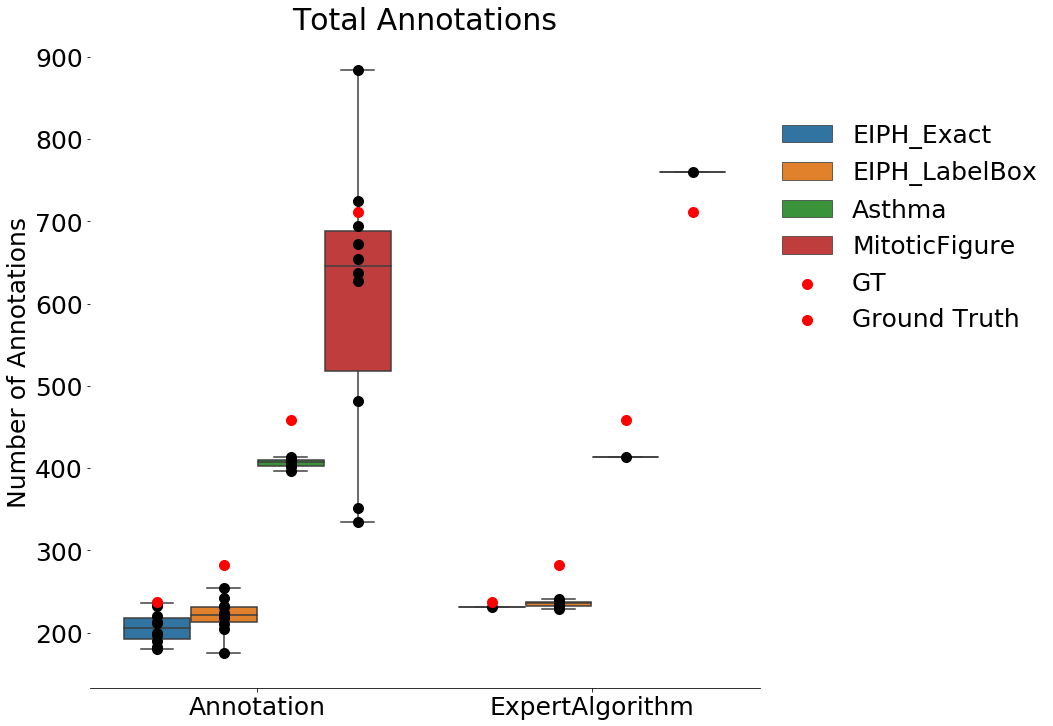

In [12]:
f, ax = plt.subplots(figsize=(12, 12))

temp = global_statistics[global_statistics["ProjectType"] != ProjectType.GroundTruth]
ax = sns.boxplot(x="ProjectType", y="Nr. Annotations", data= temp, showfliers=False, hue='Dataset', whis=np.inf,
                 hue_order=[DatasetType.EIPH_Exact, DatasetType.EIPH_LabelBox, DatasetType.Asthma, DatasetType.MitoticFigure])

for index, row in enumerate(global_statistics.values.tolist()):
    name  = row[0]
    dataset = row[1]
    project_type = row[2]
    value = row[3]
    
    type_offset = -0.3
    if dataset == DatasetType.EIPH_LabelBox:
        type_offset = -0.1
    elif dataset == DatasetType.Asthma:
        type_offset = 0.1
    elif dataset == DatasetType.MitoticFigure:
        type_offset = 0.3

    if project_type == ProjectType.Annotation:
        plt.scatter(x=0 + type_offset, y=value, s=100, zorder=100, c='black')  
    elif project_type == ProjectType.ExpertAlgorithm:
        plt.scatter(x=1 + type_offset, y=value, s=100, zorder=100, c='black')  
    else: # GT
        plt.scatter(x=0 + type_offset, y=value, s=100, zorder=110, c='red', label="GT")
        plt.scatter(x=1 + type_offset, y=value, s=100, zorder=110, c='red', label="Ground Truth")  
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1., 0.9), frameon=False)

ax.set(ylabel="Number of Annotations", xlabel="", title="Total Annotations")
sns.despine(left=True)

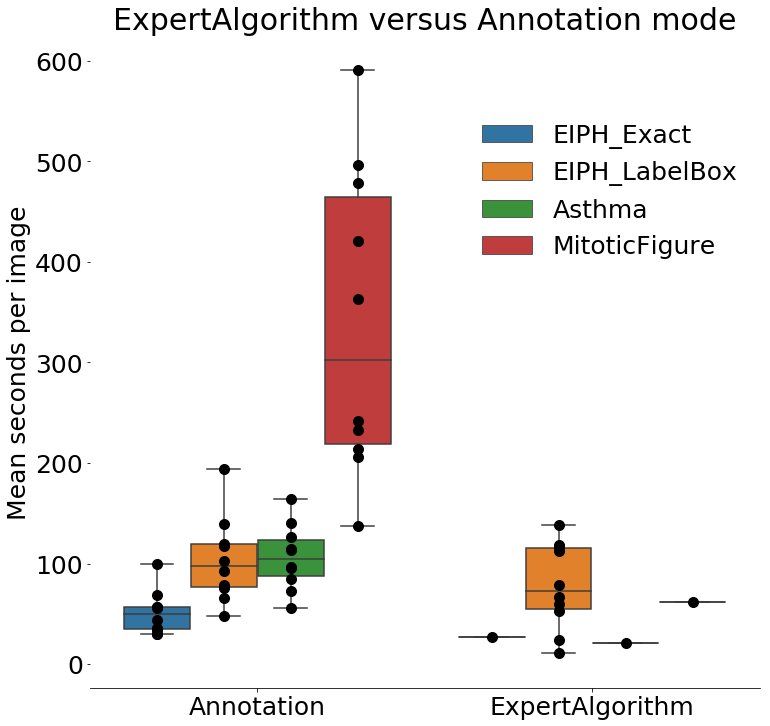

In [13]:
f, ax = plt.subplots(figsize=(12, 12))

temp = global_statistics[global_statistics["ProjectType"] != ProjectType.GroundTruth]
ax = sns.boxplot(x="ProjectType", y="Seconds", data= temp, showfliers=False, hue='Dataset', whis=np.inf, 
                 hue_order=[DatasetType.EIPH_Exact, DatasetType.EIPH_LabelBox, DatasetType.Asthma, DatasetType.MitoticFigure])

for index, row in enumerate(global_statistics.values.tolist()):
    name  = row[0]
    dataset = row[1]
    project_type = row[2]
    value = row[4]
    
    type_offset = -0.3
    if dataset == DatasetType.EIPH_LabelBox:
        type_offset = -0.1
    elif dataset == DatasetType.Asthma:
        type_offset = 0.1
    elif dataset == DatasetType.MitoticFigure:
        type_offset = 0.3

    if project_type == ProjectType.Annotation:
        plt.scatter(x=0 + type_offset, y=value, s=100, zorder=100, c='black')  
    elif project_type == ProjectType.ExpertAlgorithm:
        plt.scatter(x=1 + type_offset, y=value, s=100, zorder=100, c='black')  
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1., 0.9), frameon=False)

ax.set(ylabel="Mean seconds per image", xlabel="", title="ExpertAlgorithm versus Annotation mode")
sns.despine(left=True)

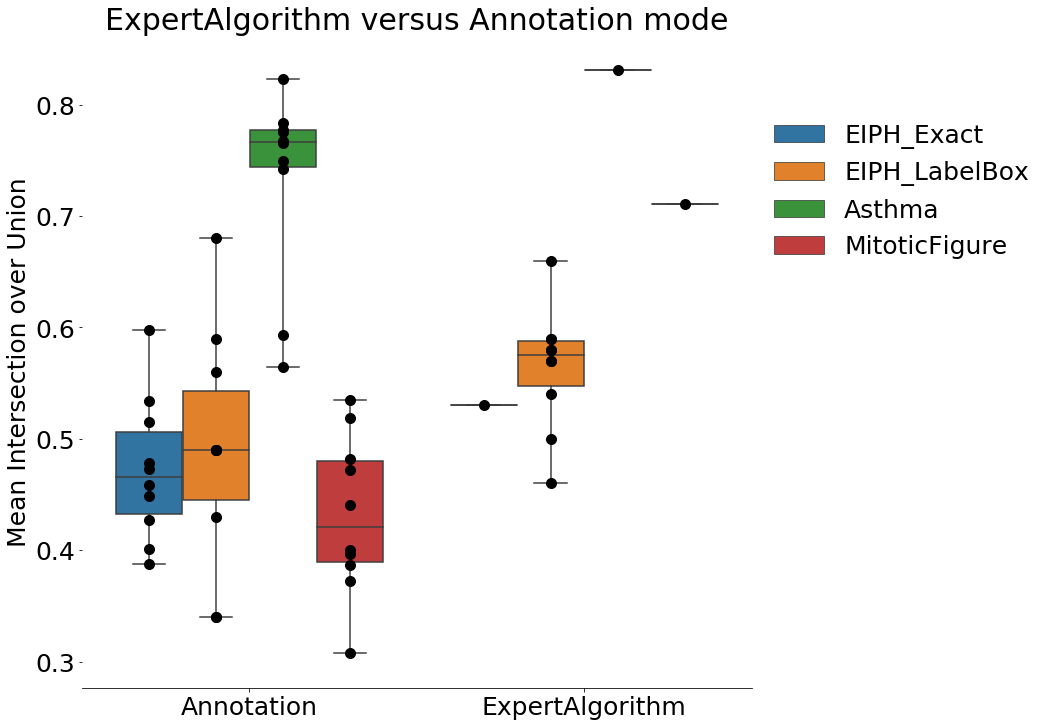

In [14]:
f, ax = plt.subplots(figsize=(12, 12))

temp = global_statistics[global_statistics["ProjectType"] != ProjectType.GroundTruth]
ax = sns.boxplot(x="ProjectType", y="mIoU", data= temp, showfliers=False, hue='Dataset', whis=np.inf, 
                 hue_order=[DatasetType.EIPH_Exact, DatasetType.EIPH_LabelBox, DatasetType.Asthma, DatasetType.MitoticFigure])

for index, row in enumerate(global_statistics.values.tolist()):
    name  = row[0]
    dataset = row[1]
    project_type = row[2]
    value = row[5]
    
    type_offset = -0.3
    if dataset == DatasetType.EIPH_LabelBox:
        type_offset = -0.1
    elif dataset == DatasetType.Asthma:
        type_offset = 0.1
    elif dataset == DatasetType.MitoticFigure:
        type_offset = 0.3

    if project_type == ProjectType.Annotation:
        plt.scatter(x=0 + type_offset, y=value, s=100, zorder=100, c='black')  
    elif project_type == ProjectType.ExpertAlgorithm:
        plt.scatter(x=1 + type_offset, y=value, s=100, zorder=100, c='black')  
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1., 0.9), frameon=False)

ax.set(ylabel="Mean Intersection over Union", xlabel="", title="ExpertAlgorithm versus Annotation mode")
sns.despine(left=True)

### Show Images

In [15]:
folder = Path('D:\\ProgProjekte\\Python\\Exact\\Converter\\result')
image_paths = glob(str(folder) + "\\astma\\*.png") + glob(str(folder) + "\\eiph\\*.png") + glob(str(folder) + "\\mitosen\\*.tiff")

image_paths = [Path(path) for path in image_paths]

path_dict = {path.name:path for path in image_paths}

path_dict.keys()

dict_keys(['BAL 1 Spray 2_12354_6185_340_265.png', 'BAL 1 Spray 2_13853_14388_239_229.png', 'BAL AIA Blickfang Luft_14276_24912_563_557.png', 'BAL AIA Blickfang Luft_18853_7806_379_819.png', 'BAL AIA Blickfang Luft_21990_7623_915_513.png', 'BAL AIA Blickfang Luft_9884_14138_740_392.png', 'BAL Booker Spray 3_10536_20178_606_288.png', 'BAL Booker Spray 3_5640_17363_421_418.png', 'BAL Booker Spray 3_5968_18111_634_641.png', 'BAL Booker Spray 3_9219_11159_811_1075.png', 'BAL Bubi Spray 1_14702_5074_552_569.png', 'BAL Bubi Spray 1_20048_7767_491_740.png', 'BAL cent blue Luft 2_14171_14271_816_471.png', 'BAL cent blue Luft 2_8074_13900_696_411.png', 'BAL cent blue Luft 2_8846_16794_505_456.png', 'BAL Promyk Spray 4_13885_15319_645_476.png', 'BAL Promyk Spray 4_14633_16023_586_641.png', 'BAL Promyk Spray 4_15080_25723_691_531.png', 'BAL Promyk Spray 4_17257_13226_856_710.png', 'BAL Promyk Spray 4_9776_19209_645_570.png', '01_EIPH_563479 Turnbull blue.png', '02_EIPH_574162 Turnbull blue-001.pn

In [129]:
file_name = '20c0753af38303691b27.tiff'

annotations = statistics.get_annotations(file_name)
annotations.head()

Name                    Vector           Label ProjectType
0  Participant_11  [6667, 4755, 6717, 4805]  mitotic figure  Annotation
1  Participant_11  [6228, 5029, 6278, 5079]  mitotic figure  Annotation
2  Participant_11  [5052, 4849, 5102, 4899]  mitotic figure  Annotation
3  Participant_11  [5364, 4916, 5414, 4966]  mitotic figure  Annotation
4  Participant_11  [5499, 5074, 5549, 5124]  mitotic figure  Annotation

In [131]:
center_anno = None
center_count = 0
radius = 2048


x_min = 0
y_min = 0
x_max = 0
y_max = 0

centers = [(anno[0] + (anno[2] - anno[0]) / 2, anno[1] + (anno[3] - anno[1]) / 2)  for anno in annotations['Vector'].values]
tree = KDTree(centers) 

for anno in annotations.values.tolist():
    name, vector, label, _ = anno
    center = [(vector[0] + (vector[2] - vector[0]) / 2, vector[1] + (vector[3] - vector[1]) / 2)]
    
    index_per_point = tree.query_radius(center, r=radius)[0]
    count = len(index_per_point)
    
    if count > center_count:
        center_count = count
        
        x_min = int(vector[0] - radius / 2)
        y_min = int(vector[1] - radius / 2)
        
        x_max = int(vector[0] + radius / 2)
        y_max = int(vector[1] + radius / 2)
        
        center_anno = anno
"{0}  {1}  {2}".format(center_anno, center_count, [x_min, y_min, x_max, y_max])        

"['Participant_8', array([4580, 3246, 4630, 3296]), 'mitotic figure', <ProjectType.Annotation: 1>]  356  [3556, 2222, 5604, 4270]"

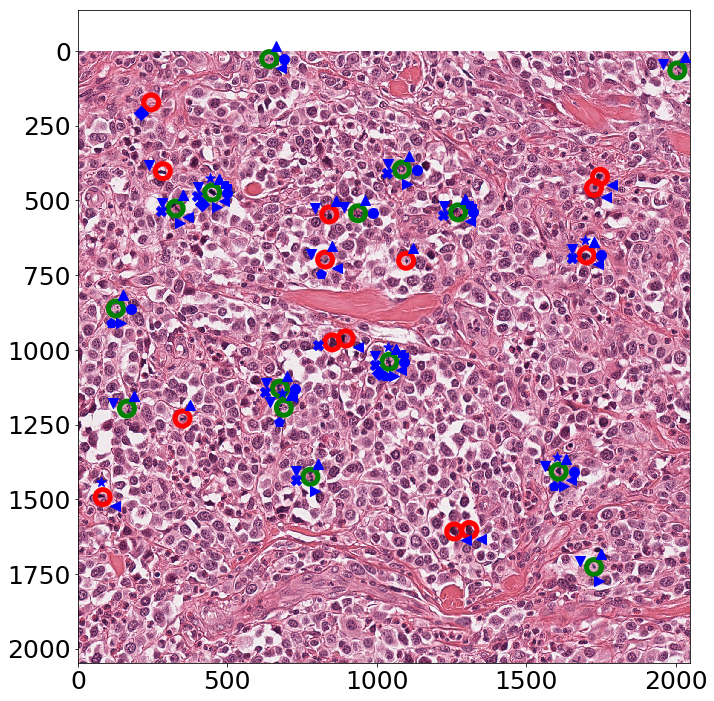

In [139]:
im = np.array(PILImage.open(str(path_dict[file_name])), dtype=np.uint8)[y_min:y_max, x_min:x_max]


fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(im)

# draw ground truth 
drawn_centers = []
for name, vector, label, project_type in annotations.values.tolist():
    if vector[0] < x_min or vector[1] < y_min or  vector[2] > x_max or vector[3] > y_max:
        continue           
    
    if project_type == ProjectType.GroundTruth:
        circle = patches.Circle((vector[0] - x_min + 25, vector[1] - y_min + 25), 25, linewidth=5, edgecolor='g', facecolor='none')
        ax.add_patch(circle)   
        
        
        center = (vector[0] + (vector[2] - vector[0]) / 2, vector[1] + (vector[3] - vector[1]) / 2)
        drawn_centers.append(center)
            


for name, vector, label, project_type in annotations.values.tolist():
    
    if vector[0] < x_min or vector[1] < y_min or  vector[2] > x_max or vector[3] > y_max or project_type == ProjectType.GroundTruth:
        continue
    
    tree = KDTree(drawn_centers) 
    
    center = (vector[0] + (vector[2] - vector[0]) / 2, vector[1] + (vector[3] - vector[1]) / 2)
    index_per_point = tree.query_radius([center], r=25)[0]
    
    circle_center = (vector[0] - x_min + 25, vector[1] - y_min + 25)
    if len(index_per_point) == 0:
        circle = patches.Circle(circle_center, 25, linewidth=5, edgecolor='r', facecolor='none')
        ax.add_patch(circle)  
        
        drawn_centers.append(center)
    else:
        circle_center = drawn_centers[index_per_point[0]]
        circle_center = (circle_center[0] - x_min, circle_center[1] - y_min)
        
        
    #  draw symbol around circle
    x = int(circle_center[0] + 50 * offset[name][0])
    y = int(circle_center[1] + 50 * offset[name][1])
    
    plt.scatter(x= x, y= y, marker=symbols[name], label=name, s=100, c='b', zorder=100)
        
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), frameon=True)
      
plt.show()

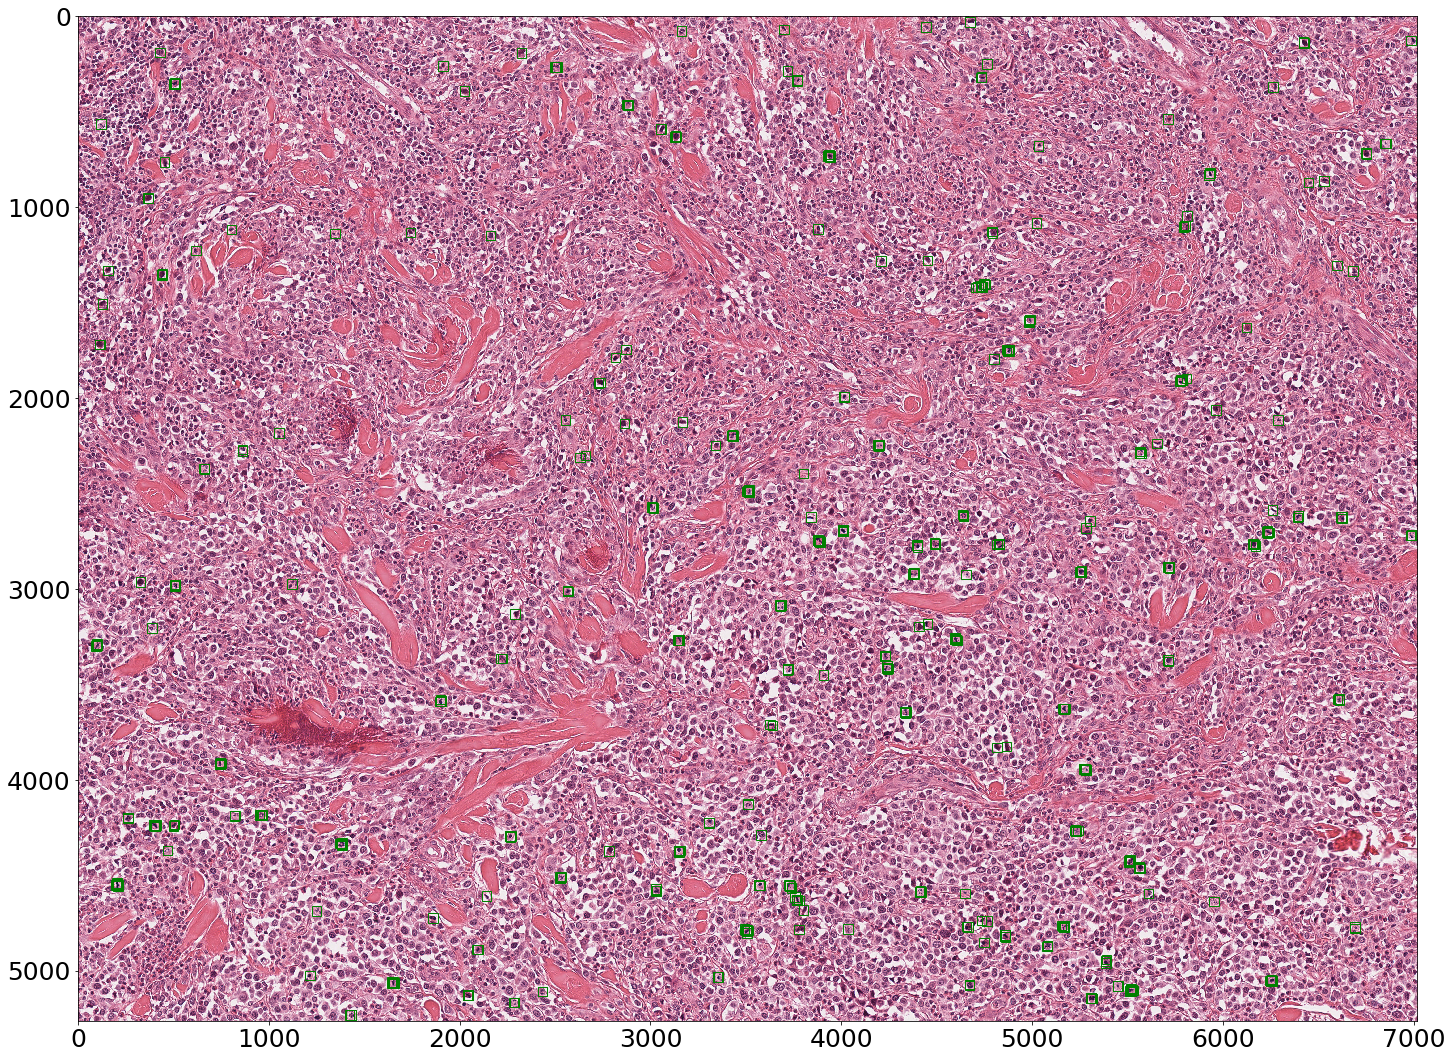

In [54]:
im = np.array(PILImage.open(str(path_dict[file_name])), dtype=np.uint8)


fig, ax = plt.subplots(figsize=(24, 24))

ax.imshow(im)

for name, vector, label in annotations.values.tolist():

    rect = patches.Rectangle((vector[0], vector[1]), vector[2] - vector[0], vector[3] - vector[1], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)     
      
plt.show()